# Lecture 24 EEP118

## Limited Dependent Variable

1. Overview- Limited Dependent (Y) variables

2. Linear Probability model

3. Logit


Study chapter 7.5 and the first section of 17.1

Posted all remaining DA and solutions 

Soon to be posted - practice final and previous year final

Quiz 6 ungraded posted - causality - impact analysis




### Limited Depedent Variable Y

The basic context of this set of lectures is when Y is not continuous

Y=0 or 1, Y is binary. YES/NO

Other cases

Y categorical variable, e.g., income ranges

Y ordered variable, 

Y truncated, e.g. lots of zeros and then Y>0 also

Y is a count variable , e.g. number of kids, 0,1,2,…

Y categorical and not ordered, e.g. major of graduates, transportation modes

The example we will use Y=1 if respondent is in labor force, =0 otherwise






Use a Data set on Women labor force participation

Source:  MROZ.RAW in Wooldridge.  T.A. Mroz (1987), “The Sensitivity of an Empirical Model of Married Women’s Hours of Work to Economic and Statistical Assumptions,” Econometrica 55, 765-799.


Y= 1 or 0  column called inlf  (short for in labor force)

Obs:   N=753

inlf                byte   %9.0g                  inlf=1 if in labor force, 1975, inlf=0 otherwise

age                byte   %9.0g                  woman's age in years

educ               byte   %9.0g                  years of schooling

kidslt6           byte   %9.0g                  # kids < 6 years

kidsge6           byte   %9.0g                  # kids 6-18

nwifeinc         float  %9.0g                  (faminc - wage*hours)/1000

hushrs            int    %9.0g                   hours worked by husband, 1975

husage           byte   %9.0g                  husband's age

huseduc          byte   %9.0g                  husband's years of schooling

huswage         float  %9.0g                  husband's hourly wage, 1975

city                   byte   %9.0g                  =1 if live in SMSA


In [1]:
#Lecture24.R
#Lecture 24

install.packages("pacman")

# Load the 'pacman' package
library(pacman) 
#packages to use load them now using the pacman "manager"
p_load(dplyr, haven, readr) 
#Another great feature of p_load(): if you try to load a package that is not installed on your machine, p_load() install the package for you, rather than throwing an error. For instance, let’s install and load one final package named ggplot2. 
p_load(ggplot2)


pacman::p_load(lfe, lmtest, haven, sandwich, tidyverse)
# lfe for running fixed effects regression
# lmtest for displaying robust SE in output table
# haven for loading in dta files
# sandwich for producing robust Var-Cov matrix
# tidyverse for manipulating data and producing plots


#The big difference with Stata that appears here is lm() by default 
#doesn't compute robust SE - we have to use additional packages/functions 
#to compute it. felm does allow for multi-way clustering by default though 
#which is nice.

#I added an alternate version of the first plots to show that we can 
#change the color of the points according to whether the prediction 
#is in [0,1] or outside of it. You can also specify factor(inlf) for 
#the latter plots of actual vs. predicted to only have the values 0 or 1 on 
#the x-axis.


pacman::p_load(lfe, lmtest, haven, sandwich, tidyverse)
# lfe for running fixed effects regression
# lmtest for displaying robust SE in output table
# haven for loading in dta files
# sandwich for producing robust Var-Cov matrix
# tidyverse for manipulating data and producing plots
install.packages(sandwich)
install.packages(lfe)
install.packages(lmtest)
install.packages(tidyverse)
library(sandwich)
library(lfe)
library(lmtest)
library(tidyverse)


# alternate plot theme for ggplot
theme_ed <- theme(
  legend.position = "bottom",
  panel.background = element_rect(fill = NA),
  # panel.border = element_rect(fill = NA, color = "grey75"),
  axis.ticks = element_line(color = "grey95", size = 0.3),
  panel.grid.major = element_line(color = "grey95", size = 0.3),
  panel.grid.minor = element_line(color = "grey95", size = 0.3),
  legend.key = element_blank())

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)

Installing package into ‘/srv/r’
(as ‘lib’ is unspecified)



ERROR: Error in as.character(x): cannot coerce type 'closure' to vector of type 'character'


In [2]:
#load data
mydata<- read_dta("Lecture24MROZ.DTA") 
#Summary stats inlf age educ kidslt6 kidsge6 nwifeinc hushrs husage huseduc huswage unem city 
summary(mydata)

      inlf            hours           kidslt6          kidsge6     
 Min.   :0.0000   Min.   :   0.0   Min.   :0.0000   Min.   :0.000  
 1st Qu.:0.0000   1st Qu.:   0.0   1st Qu.:0.0000   1st Qu.:0.000  
 Median :1.0000   Median : 288.0   Median :0.0000   Median :1.000  
 Mean   :0.5684   Mean   : 740.6   Mean   :0.2377   Mean   :1.353  
 3rd Qu.:1.0000   3rd Qu.:1516.0   3rd Qu.:0.0000   3rd Qu.:2.000  
 Max.   :1.0000   Max.   :4950.0   Max.   :3.0000   Max.   :8.000  
                                                                   
      age             educ            wage            repwage    
 Min.   :30.00   Min.   : 5.00   Min.   : 0.1282   Min.   :0.00  
 1st Qu.:36.00   1st Qu.:12.00   1st Qu.: 2.2626   1st Qu.:0.00  
 Median :43.00   Median :12.00   Median : 3.4819   Median :0.00  
 Mean   :42.54   Mean   :12.29   Mean   : 4.1777   Mean   :1.85  
 3rd Qu.:49.00   3rd Qu.:13.00   3rd Qu.: 4.9708   3rd Qu.:3.58  
 Max.   :60.00   Max.   :17.00   Max.   :25.0000   Max.   :9

## Two problems linear prob model

### Problem 1: We violate homoscedasticity: Var(y|x)=p(x) (1-p(x)). Depends on x!!!

### Problem 2: For certain values of x we can have y hat < 0 or > 1


# Fixing Problem 1 - correct Standard errors for heteroskedacitity

In [3]:
######## Fixing Problem 1 of Heteroskedasticity -------------
reg1 <- lm(inlf ~ nwifeinc + educ + age + kidslt6 + kidsge6, mydata)
summary(reg1)

# note that lm() uses regular standarde errors by default so we won't use summary here
# to get robust, we can use the following combo of coeftest() with vcovHC()
# HC1 is the Stata default for ",robust" but we could specify many alternate versions of var-cov matrix here

#correct standard errors
coeftest(reg1, vcov = vcovHC(reg1, "HC1"))


Call:
lm(formula = inlf ~ nwifeinc + educ + age + kidslt6 + kidsge6, 
    data = mydata)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9345 -0.4762  0.1910  0.3808  0.9379 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.644779   0.160657   4.013 6.59e-05 ***
nwifeinc    -0.006844   0.001515  -4.518 7.25e-06 ***
educ         0.052459   0.007802   6.724 3.51e-11 ***
age         -0.011679   0.002542  -4.594 5.10e-06 ***
kidslt6     -0.296804   0.035789  -8.293 5.12e-16 ***
kidsge6     -0.011692   0.013970  -0.837    0.403    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4594 on 747 degrees of freedom
Multiple R-squared:  0.1466,	Adjusted R-squared:  0.1409 
F-statistic: 25.66 on 5 and 747 DF,  p-value: < 2.2e-16



t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.6447792  0.1555271  4.1458 3.775e-05 ***
nwifeinc    -0.0068444  0.0015309 -4.4708 9.001e-06 ***
educ         0.0524590  0.0072904  7.1956 1.516e-12 ***
age         -0.0116789  0.0024414 -4.7837 2.074e-06 ***
kidslt6     -0.2968039  0.0329886 -8.9972 < 2.2e-16 ***
kidsge6     -0.0116920  0.0143619 -0.8141    0.4158    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [4]:

# get predictions (adding them into our df)
mydata <- mutate(mydata, reg_fit = reg1$fitted.values)

#to plot them next

# Showing Problem 2 that some predictions are negative and some greater than 1


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


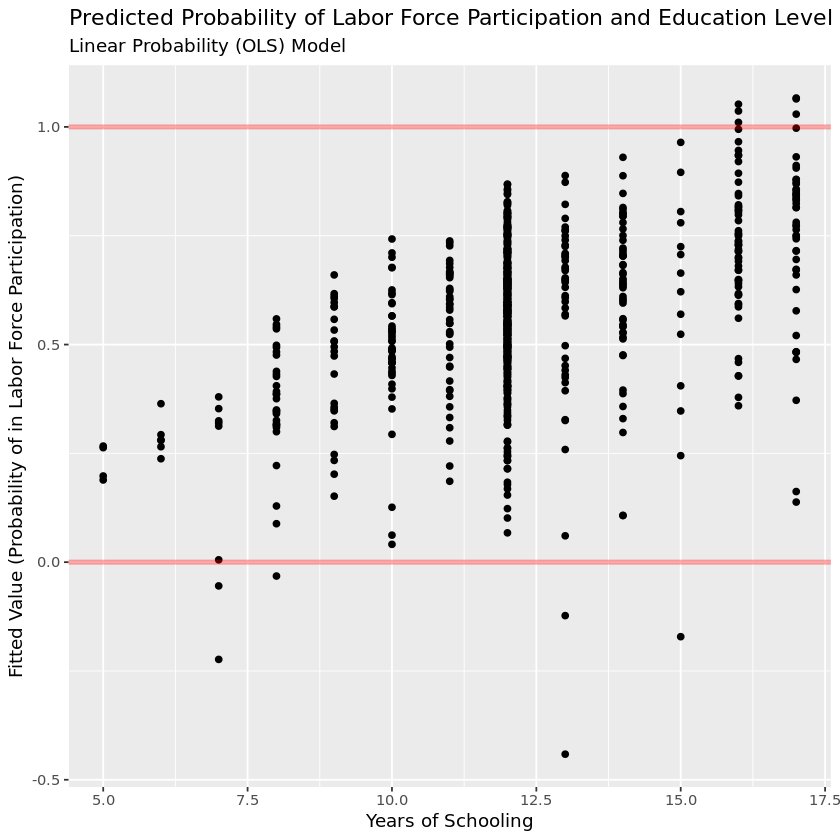

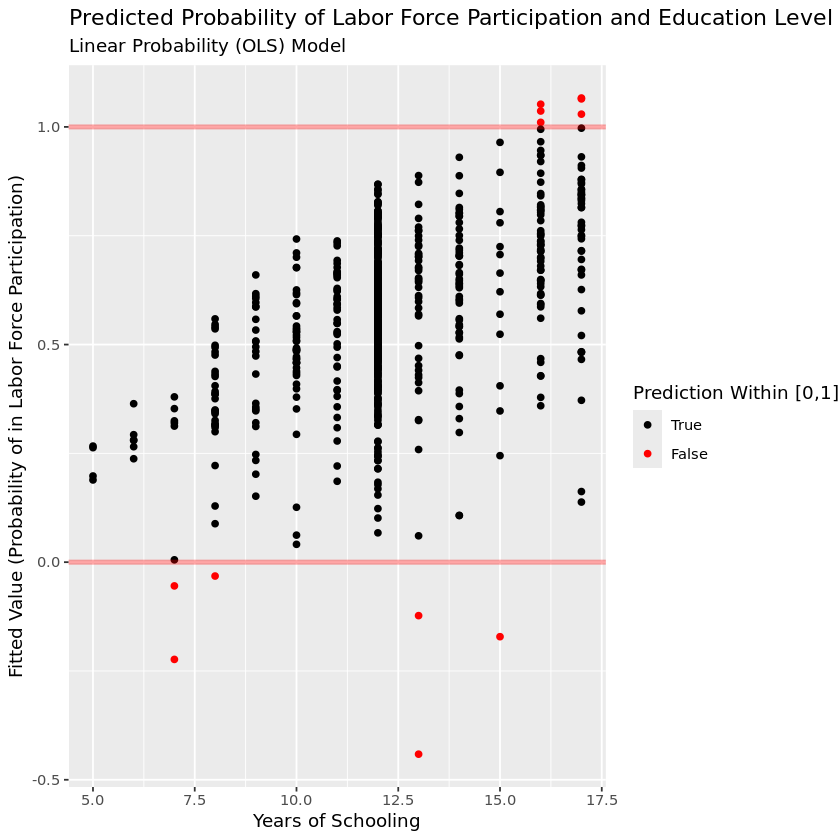

In [5]:
# plot predicted values and education
# set data and aesthetics (x and y vars here since the same for all elements)
ggplot(mydata, aes(x = educ, y = reg_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point() + # add points
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted Probability of Labor Force Participation and Education Level",
       subtitle = "Linear Probability (OLS) Model",
       x = "Years of Schooling",
       y = "Fitted Value (Probability of in Labor Force Participation)")

# alternate version of the figure where we change the color of fitted values < 0 or > 1
# first create logical variable of whether fitted value is within [0,1]
mydata <- mutate(mydata, reg_outside = reg_fit < 0 | reg_fit > 1)
# now use this variable to determine color of points
# set data and aesthetics (x and y vars here since the same for all elements)
ggplot(mydata, aes(x = educ, y = reg_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point(aes(colour = factor(reg_outside))) + 
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted Probability of Labor Force Participation and Education Level",
       subtitle = "Linear Probability (OLS) Model",
       x = "Years of Schooling",
       y = "Fitted Value (Probability of in Labor Force Participation)") +
  # Manually set the color scale to the title we want and the colors
  scale_colour_manual(name = "Prediction Within [0,1]?",
                      values = c("black", "red"),
                      labels = c("True", "False"))




what do we see? 

for example

A woman with 3 kids, age 31 nwifeinc=73.6 is observed not working and we predict  for her Y hat < 0

see the red dot in the above graph


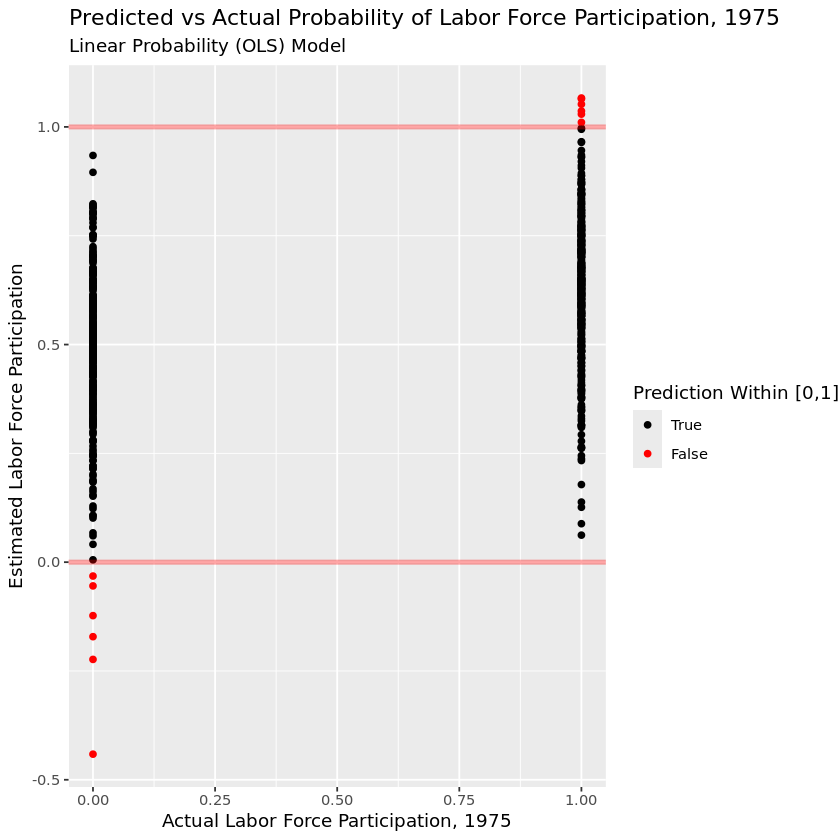

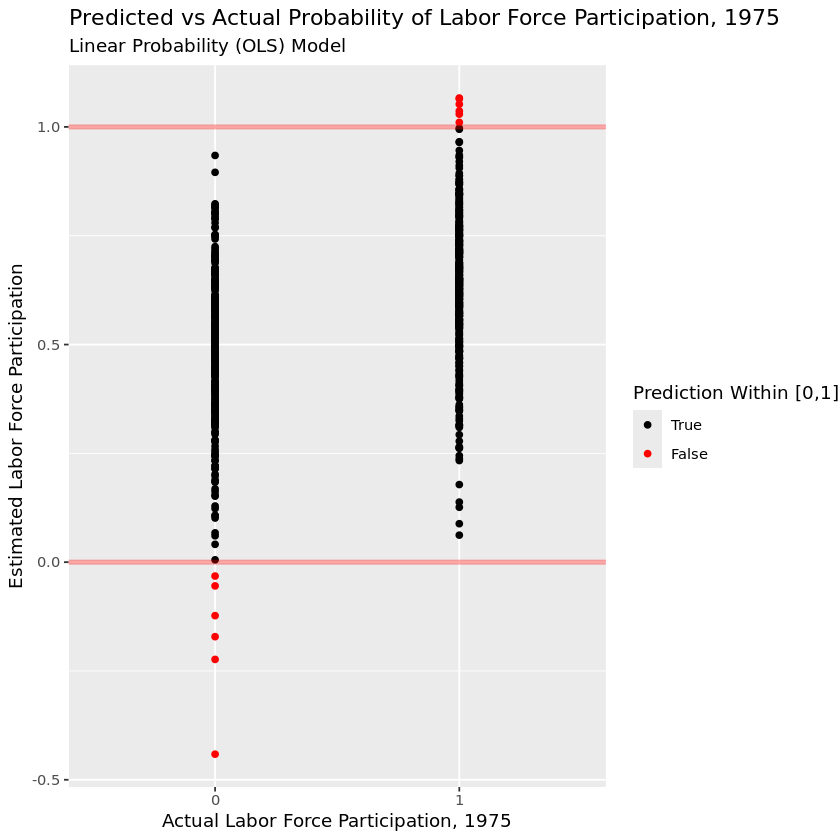

In [6]:
# Plot 2 ------------
# Produce second plot for actual y
# set data and aesthetics (x and y vars here since the same for all elements)
ggplot(mydata, aes(x = inlf, y = reg_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point(aes(colour = factor(reg_outside))) + 
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted vs Actual Probability of Labor Force Participation, 1975",
       subtitle = "Linear Probability (OLS) Model",
       x = "Actual Labor Force Participation, 1975",
       y = "Estimated Labor Force Participation") +
  # Manually set the color scale to the title we want and the colors
  scale_colour_manual(name = "Prediction Within [0,1]?",
                      values = c("black", "red"),
                      labels = c("True", "False"))

# Specifying x as factor simplifies the plot to only show 0 or 1 for x-axis
# set data and aesthetics (x and y vars here since the same for all elements)
ggplot(mydata, aes(x = factor(inlf), y = reg_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point(aes(colour = factor(reg_outside))) + 
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted vs Actual Probability of Labor Force Participation, 1975",
       subtitle = "Linear Probability (OLS) Model",
       x = "Actual Labor Force Participation, 1975",
       y = "Estimated Labor Force Participation") +
  # Manually set the color scale to the title we want and the colors
  scale_colour_manual(name = "Prediction Within [0,1]?",
                      values = c("black", "red"),
                      labels = c("True", "False"))

What do we see? 

we predict some above 1 and some below 0


# Fixing Problem 2, make sure predictions are between 0 and 1

Solution Problem 1 – 

use a functional for for the probability as a function G( ) of the xs that stays between 0 and 1  

e.g., the Logit Model!


the ratio of exponents in the logit below is always between 0 and 1


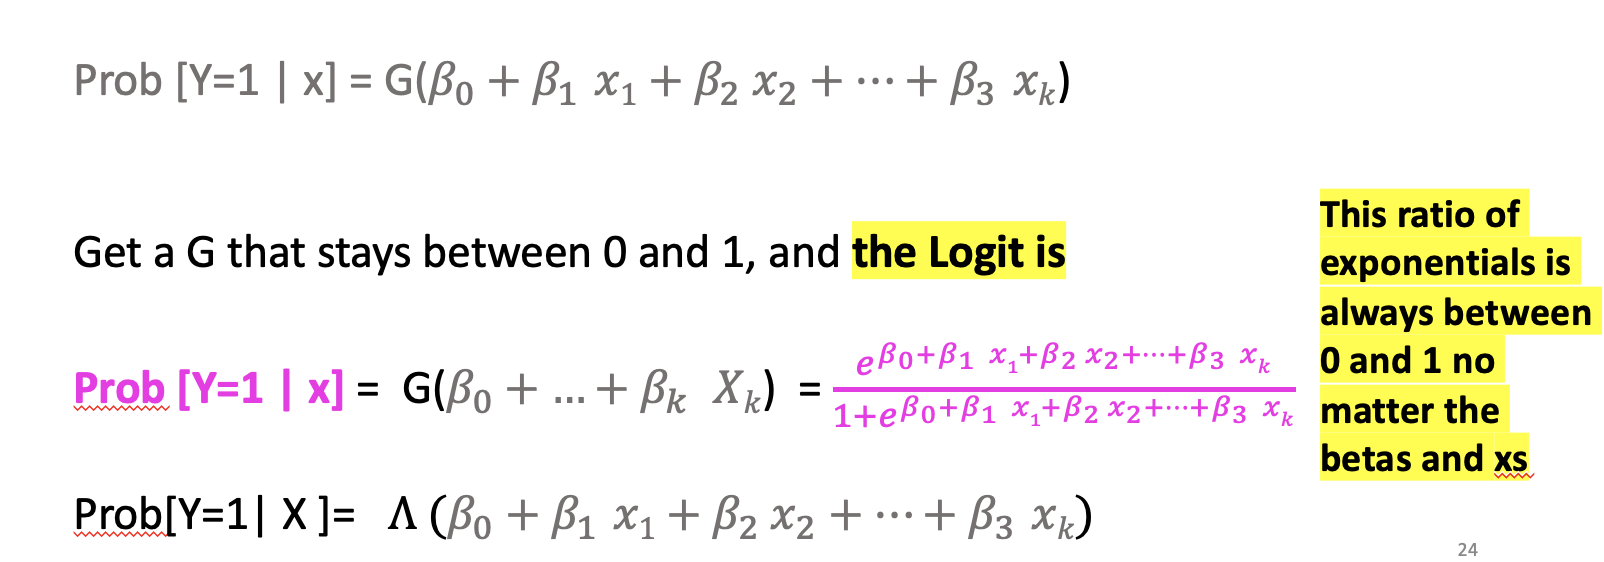

In [7]:
###### Fixing Problem 2 so that predicted Y hats are less than 1 and greater than 0 --------------
# In R, use the glm(formula, data, family = binomial(link = "logit")) function

logit <- glm(inlf ~ nwifeinc + educ + age + kidslt6 + kidsge6, mydata, family = binomial(link = "logit"))
summary(logit)




Call:
glm(formula = inlf ~ nwifeinc + educ + age + kidslt6 + kidsge6, 
    family = binomial(link = "logit"), data = mydata)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.722993   0.788698   0.917    0.359    
nwifeinc    -0.034891   0.007884  -4.426 9.62e-06 ***
educ         0.257965   0.040744   6.331 2.43e-10 ***
age         -0.057553   0.012737  -4.519 6.23e-06 ***
kidslt6     -1.484437   0.198013  -7.497 6.55e-14 ***
kidsge6     -0.066363   0.067856  -0.978    0.328    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1029.75  on 752  degrees of freedom
Residual deviance:  908.37  on 747  degrees of freedom
AIC: 920.37

Number of Fisher Scoring iterations: 4


Cannot easily interpret parameters here, 

next class estimate implied marginal effects given the above estimated Logit parameters 

 . . . . . . . More on the logit model next class


In [8]:
#generate predictions
mydata <- mutate(mydata, log_fit = logit$fitted.values) # add in the logit fitted values

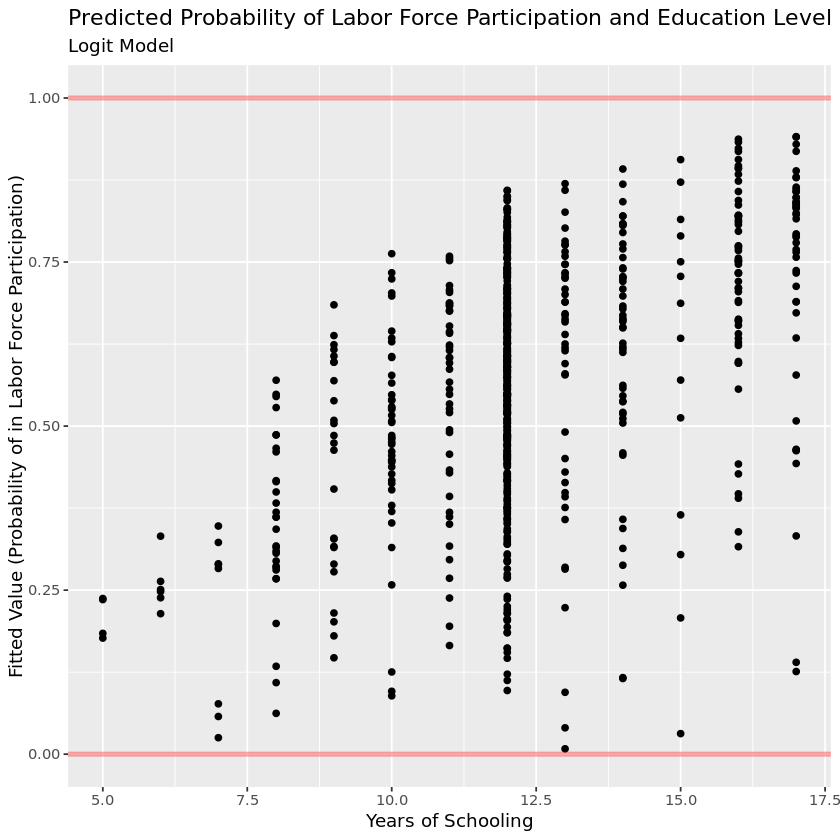

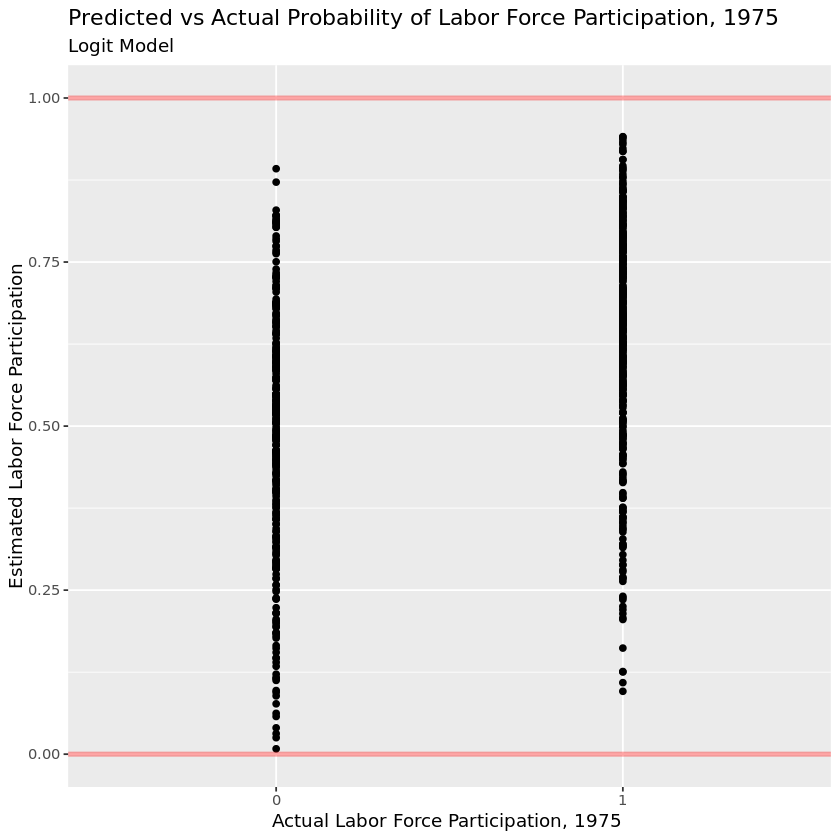

In [9]:
# Reproduce figures for logit
# no need to use the second approach as we're always within [0,1] with logit
# set data and aesthetics (x and y vars here since the same for all elements)
ggplot(mydata, aes(x = educ, y = log_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point() + # add points
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted Probability of Labor Force Participation and Education Level",
       subtitle = "Logit Model",
       x = "Years of Schooling",
       y = "Fitted Value (Probability of in Labor Force Participation)")

# actual vs predicted
ggplot(mydata, aes(x = factor(inlf), y = log_fit)) +
  # First add points, color determined by whether in or out of [0,1]
  geom_point() + 
  # add horizontal lines, width slightly wider, making partially transparent, and choosing color
  geom_hline(yintercept=0, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=0
  geom_hline(yintercept=1, size = 1.4, alpha = 0.35, color = "red") + # add horizontal line at y=1
  # generate labels
  labs(title = "Predicted vs Actual Probability of Labor Force Participation, 1975",
       subtitle = "Logit Model",
       x = "Actual Labor Force Participation, 1975 ",
       y = "Estimated Labor Force Participation")


Looking at the graph above, all predictions now are between 0 and 1


more in Lecture 25